In [ ]:
!pip install google-genai

In [60]:
# To run this code you need to install the following dependencies:
# pip install google-genai

import base64
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
import json
import random
import sys
import json
import re
sys.path.append('..')
import src.utils.visualizer as visualizer
load_dotenv()

True

In [69]:
def gemini_generate(model, prompt):
    client = genai.Client(
        api_key=os.environ.get("GOOGLE_GEMINI_API_KEY_1"),
    )
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    tools = [
        types.Tool(googleSearch=types.GoogleSearch(
        )),
    ]
    generate_content_config = types.GenerateContentConfig(
        thinking_config = types.ThinkingConfig(
            thinking_budget=-1,
        ),
        tools=tools,
    )
    result = ""
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        result += chunk.text

    return result


In [20]:
GPT_PROMPT = """
You are given some example input→output grid pairs (JSON) and one test input grid (JSON).
Each grid is a 2D array of integers 0–9 representing colors:
0 Black, 1 Blue, 2 Red, 3 Green, 4 Yellow, 5 Gray, 6 Magenta, 7 Orange, 8 Light Blue, 9 Dark Red.

TASK (high-level)
  1) Carefully STUDY the relationship between each input grid and its corresponding output grid.
  2) ANALYZE what operations or transformations (if any) are applied to produce each output from its input.
     - Consider operations such as: color remapping, fill/erase, translation, rotation, reflection, local neighborhood rules,
       copying/repeating patterns, shape extraction/insertion, resizing/padding, aggregation/count-based rules, masking,
       conditional changes based on counts/positions, or composition of multiple operations.
  3) PROVIDE a DETAILED, step-by-step Chain-of-Thought (CoT) that (a) explains your analysis of the input→output relationships,
     (b) shows candidate operations you considered, (c) selects the majority hypothesis with justification, and (d) applies the
     selected rule to the TEST INPUT to produce the final output grid.
  4) PROVIDE a concise SUMMARY (≤ 3 sentences) that states the rule succinctly and any shape/size changes to the grid.

STRICT OUTPUT INSTRUCTIONS — MUST be followed exactly
  1) Return EXACTLY one JSON code block (triple-backtick fenced) and NOTHING else.
  2) The JSON object inside the code block MUST contain the keys:
      - "cot"       : string. A LONG chain-of-thought.
      - "summary"   : string. ≤ 3 sentences summarizing the rule and final output.
      - "output"    : 2D array (list of lists) of integers — the final output grid for the test input (clean JSON).
  3) DO NOT include any extra text, Markdown, or commentary outside the single JSON code block.
  

REQUIREMENTS FOR THE CHAIN-OF-THOUGHT (inside "cot")
  - Use numbered steps (1., 2., 3., ...) and include:
      1) Observations per example: for each example, give concise measurable observations:
         - cell counts per color, bounding boxes of non-zero shapes, repeated patterns, symmetry, positions of distinctive pixels,
           shape sizes, adjacency relations, and any coordinate-anchored features.
      2) Relationship analysis: explicitly describe how each observable feature in the input maps to features in the output
      6) Verification: demonstrate why the predicted final output is consistent with the rule and with the majority examples.

REQUIREMENTS FOR "summary"
  - ≤ 3 sentences.
  - Succinctly state the transformation rule(s), any change in grid dimensions, and whether exceptions/outliers exist.

REQUIREMENTS FOR "hypotheses" (optional)
  - Up to 3 alternative rules, each as an object with fields "rule" and numeric "confidence" between 0.0 and 1.0.

OUTPUT JSON SCHEMA (EXACT FORMAT — do not modify the keys; this is an example of the schema, do NOT fill these fields here):
```json
{{
  "cot": "1) Observation: ...\\n2) Relationship analysis: ...\\n3) Hypotheses: ...\\n4) Selected: ...\\n5) Apply to test input: ...\\nVerification: ...",
  "summary": "Short 1-3 sentence summary of the inferred rule and final output.",
}}
````

NOW INSERT THE PROBLEM INPUTS BELOW (replace the placeholders programmatically):

Examples (JSON array):
{examples}

Test input (JSON array):
{test_input}

REMEMBER: Return ONLY one JSON code block that follows the schema above with keys 'cot', 'summary'
"""


In [64]:
GEMINI_PROMPT = """ 
You are an expert in analyzing visual patterns and inferring transformation rules between grids of colored cells. Your task is to deduce the underlying rule(s) from a set of input-output grid examples and then apply these rule(s) to a new test input grid to get its output and provide detailed reasoning and summary in a structured format.
You are given some example input→output grid pairs (JSON) and one test input grid (JSON) and the corresponding test output grid (JSON).
Each grid is a 2D array of integers 0–9 representing colors:
0 Black, 1 Blue, 2 Red, 3 Green, 4 Yellow, 5 Gray, 6 Magenta, 7 Orange, 8 Light Blue, 9 Dark Red.

---

**CRITICAL CONSTRAINT: DO NOT USE THE PROVIDED TEST OUTPUT FOR REASONING**

The test output is provided *only* so you understand the expected output *format* and to help you align your reasoning style with a human who *knows* what a correct output looks like. Your reasoning process (Chain-of-Thought) MUST mimic how a human would infer patterns and apply them *without ever seeing the answer*. Therefore, you must **NOT cite, quote, copy, or refer to the provided test output anywhere inside the Chain-of-Thought ("cot")**. You may use the test output solely for understanding the *structure* and *format* of the expected output.

---

**YOUR HIGH-LEVEL TASK:**

1.  **Analyze Example Pairs:** Carefully study the relationship between each input grid and its corresponding output grid among the examples.
2.  **Infer Rule(s):** Analyze what operations or transformations (if any) are applied to produce each output from its input. Consider operations such as color remapping, fill/erase, translation, rotation, reflection, local neighborhood rules, copying/repeating patterns, shape extraction/insertion, resizing/padding, aggregation/count-based rules, masking, conditional changes, or compositions of multiple operations.
3.  **Generate Chain-of-Thought (CoT):** Produce a DETAILED, human-style, step-by-step reasoning process describing how you inferred the pattern(s) and how those pattern(s) would be applied to the TEST INPUT.
4.  **Generate Summary:** Produce a concise summary (≤ 3 sentences) that states the inferred rule(s) succinctly and notes any shape/size changes or exceptions.

---

**STRICT OUTPUT INSTRUCTIONS — YOU MUST FOLLOW THESE EXACTLY:**

*   Return **EXACTLY one JSON code block** (triple-backtick fenced) and NOTHING else.
*   The JSON object inside that single code block MUST contain **only** these two keys: `"cot"` and `"summary"`.
*   Do NOT include any other keys or any text or commentary outside the single JSON code block.
*   The "cot" MUST NOT contain or mention the provided test output.
*   The "cot" MUST use numbered steps as detailed below and be written in a clear, human-like reasoning style.

---

**GUIDELINES FOR THE CHAIN-OF-THOUGHT ("cot" key):**

The "cot" must be a single string containing a series of numbered steps, each on a new line (use `\n` for newlines). These steps should logically progress through your analysis and application.

**Mandatory Numbered Sections (match these names and order precisely):**

1.  **Observation example #1:** Provide concise, measurable facts for the first example pair (e.g., cell counts per color, bounding boxes of non-zero shapes, repeated patterns, symmetry, positions of distinctive pixels, shape sizes, adjacency relations, coordinate-anchored features).
2.  **Observation example #2:** Provide concise, measurable facts for the second example pair.
    *(If more examples are provided, continue with "Observation example #3:", "Observation example #4:", and so on, for each example.)*
    *Note: The number of "Observation example" steps should correspond to the number of input-output pairs given in `examples`.*
3.  **Relationship analysis:** Describe how observable features and patterns map from input to output across all examples (e.g., "color 2 within 3x3 block -> becomes color 5 and shifts right by 1"). Identify consistent mappings, transformations, or operations.
4.  **Apply to test input (representative mapping):** Demonstrate on representative cells/regions how you would apply the chosen rule(s) to the TEST INPUT. Describe step-by-step how specific cells, shapes, or regions would change (e.g., "cell (r,c) with color X -> becomes Y because..."). *Do NOT show the final output grid.*
5.  **Verification approach & confidence:** Explain how you would verify the predicted output using your inferred rule(s) (e.g., exact-match check, tile-wise comparison, invariant checks). *Do not perform the verification itself using the provided test output.*

---

**GUIDELINES FOR THE SUMMARY ("summary" key):**

*   Must be **≤ 3 sentences**.
*   Succinctly state the inferred rule(s), including any changes in grid dimensions, and mention whether there are known exceptions or ambiguities in the rule.

---

**OUTPUT JSON SCHEMA (EXACT — DO NOT MODIFY KEYS OR STRUCTURE):**

```json
{{
  "cot": "Step by Step detailed Chain-of-Thought reasoning as specified above.",
  "summary": "One- to three-sentence summary of the inferred rule(s) and exceptions."
}}
```

Below are the example pairs (in JSON format):
{examples}

Now, here is the test input and output grid (in JSON format):
{test}

You need to generate reasoning for the test input according to the provided examples to find the patterns. You MUST follow the output instructions exactly.
"""

In [32]:
dataset_dir = "/Users/bhushanshah/Documents/ARC-AGI-2/data/arc-agi-2025/problem_augmented/"
raw_dir = "/Users/bhushanshah/Documents/ARC-AGI-2/data/arc-agi-2025/raw/"
challenges_path = os.path.join(dataset_dir, "arc-agi_training_challenges.json")
solutions_path = os.path.join(dataset_dir, "arc-agi_training_solutions.json")
raw_challenges_path = os.path.join(raw_dir, "arc-agi_training_challenges.json")
raw_solutions_path = os.path.join(raw_dir, "arc-agi_training_solutions.json")

In [33]:
#load challenges and solutions
with open(challenges_path, 'r') as f:
    challenges = json.load(f)

with open(solutions_path, 'r') as f:
    solutions = json.load(f)

with open(raw_challenges_path, 'r') as f:
    raw_challenges = json.load(f)

with open(raw_solutions_path, 'r') as f:
    raw_solutions = json.load(f)


In [23]:
print("The no. of challenges loaded:", len(challenges))
print("The no. of solutions loaded:", len(solutions))

The no. of challenges loaded: 25824
The no. of solutions loaded: 25824


In [26]:
#Sample 10 challenges randomly and their corresponding solutions
sample_challenge_ids = random.sample(list(challenges.keys()), 10)
sample_challenges = {}
sample_solutions = {}
for cid in sample_challenge_ids:
    sample_challenges[cid] = challenges[cid]
    sample_solutions[cid] = solutions[cid]

In [28]:
print("Sample challenges IDs:", sample_challenge_ids)

Sample challenges IDs: ['239be575_2', '11852cab_17', 'a78176bb_22', '4e7e0eb9_43', '539a4f51_7', 'd968ffd4_37', 'c87289bb_1', 'e9fc42f2_35', '5bd6f4ac_6', '78e78cff_14']


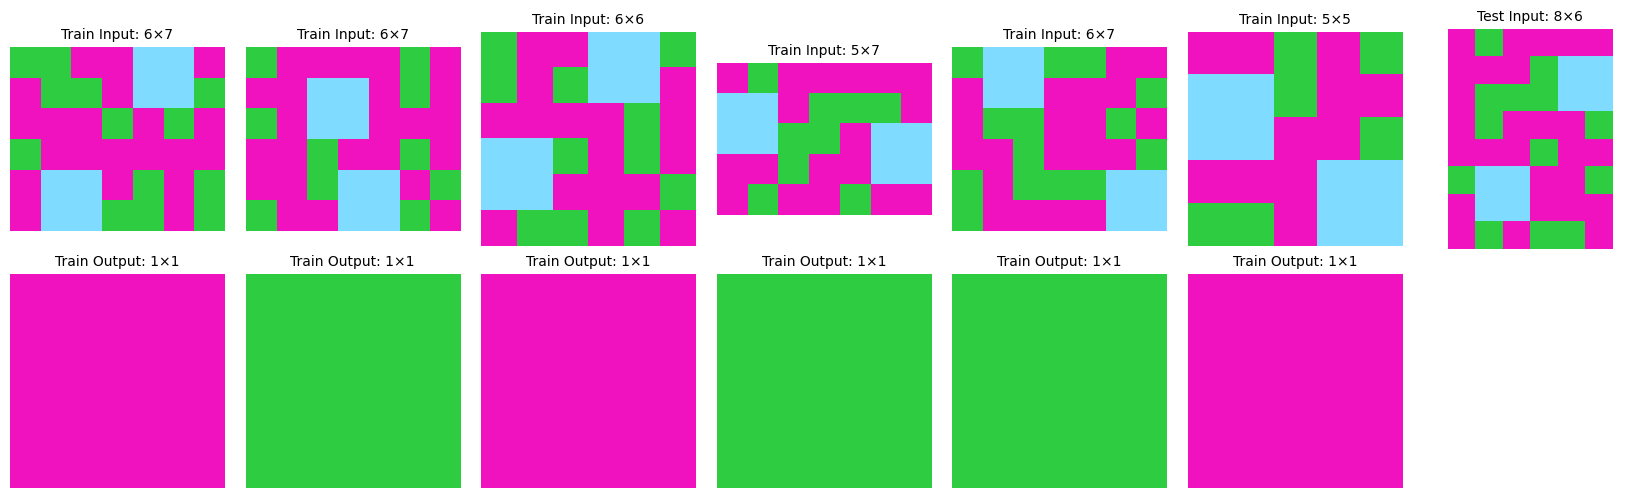

In [34]:
visualizer.plot_task(sample_challenges[sample_challenge_ids[0]])

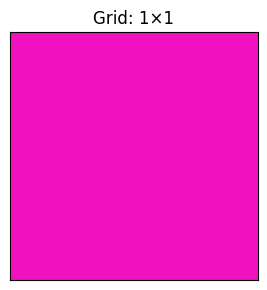

In [38]:
visualizer.plot_figure(sample_solutions[sample_challenge_ids[0]])

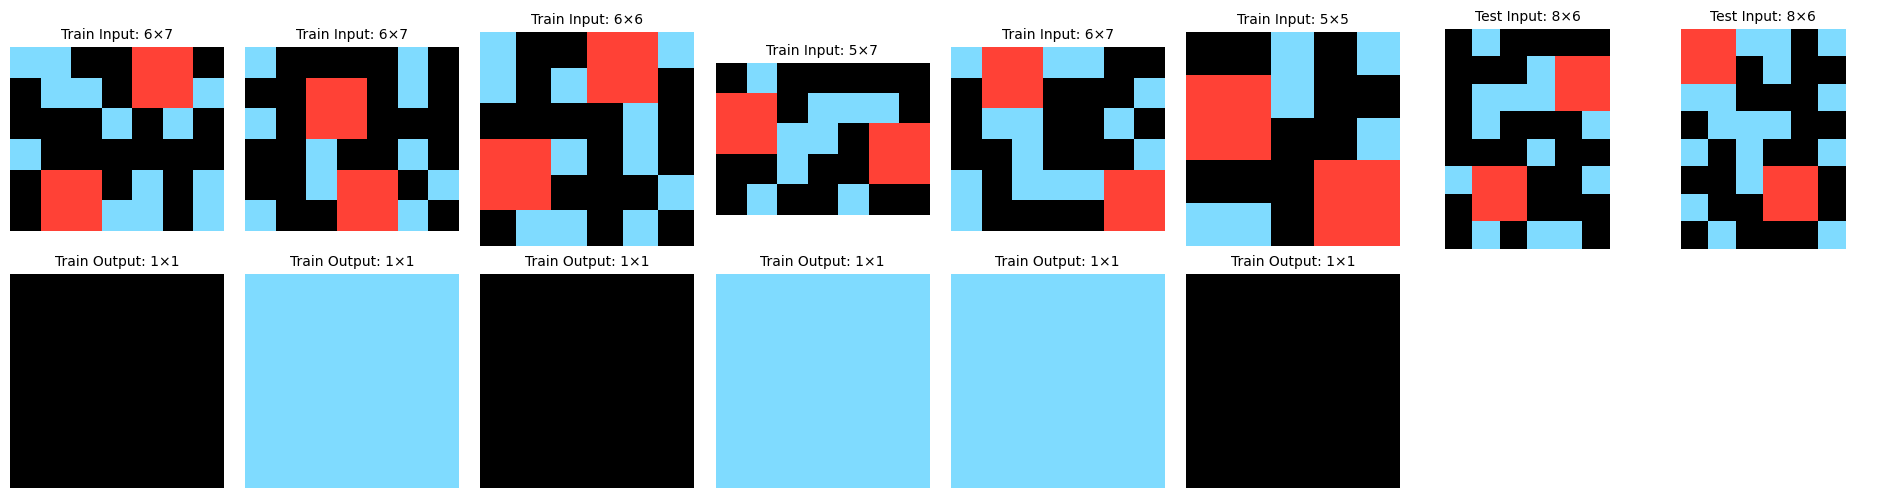

In [37]:
visualizer.plot_task(raw_challenges[sample_challenge_ids[0].split('_')[0]])

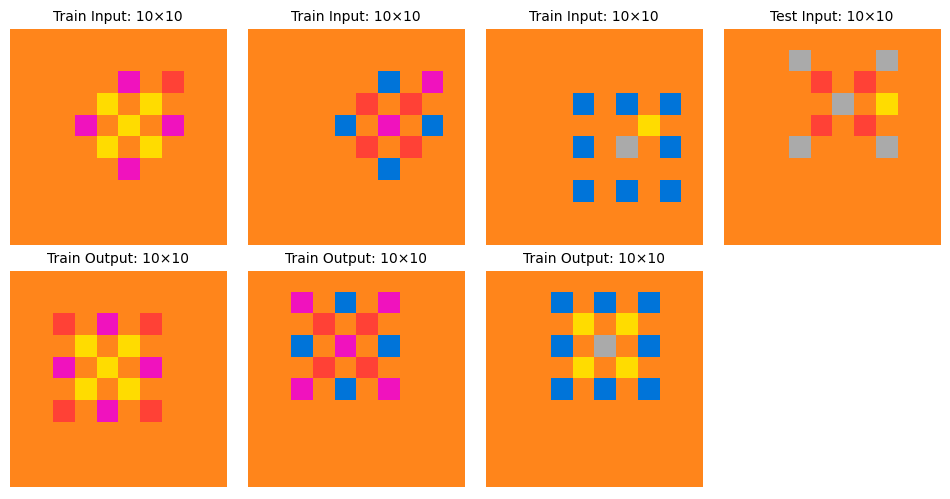

In [39]:
visualizer.plot_task(sample_challenges[sample_challenge_ids[1]])

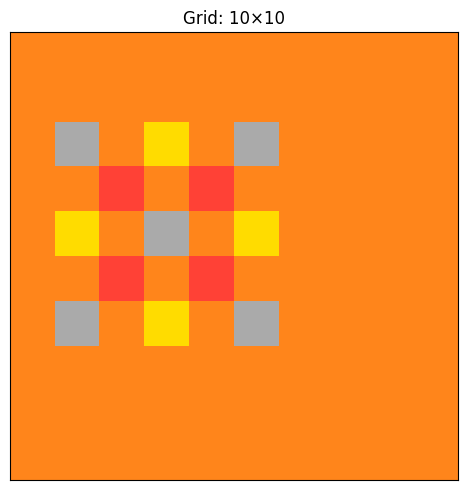

In [40]:
visualizer.plot_figure(sample_solutions[sample_challenge_ids[1]])

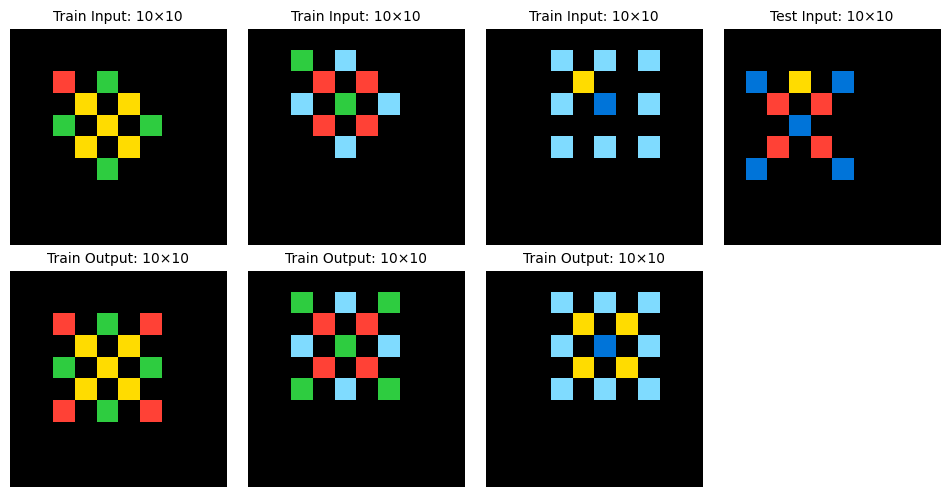

In [41]:
visualizer.plot_task(raw_challenges[sample_challenge_ids[1].split('_')[0]])

In [ ]:
def extract_json_from_string(text):
    """
    Extract JSON from a string that may contain additional text.
    Handles both regular JSON and JSON in markdown code blocks.
    
    Args:
        text (str): The input string containing JSON and possibly other text
        
    Returns:
        dict: Parsed JSON as a dictionary, or None if no valid JSON found
    """
    
    # Try to extract JSON from markdown code blocks first
    # Pattern for ```json ... ``` or ``` ... ```
    markdown_pattern = r'```(?:json)?\s*\n?(.*?)\n?```'
    markdown_matches = re.findall(markdown_pattern, text, re.DOTALL)
    
    for match in markdown_matches:
        try:
            return json.loads(match.strip())
        except json.JSONDecodeError:
            continue
    
    # If no markdown blocks, try to find JSON objects or arrays
    # Look for { ... } or [ ... ]
    json_patterns = [
        r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}',  # Simple nested objects
        r'\[[^\[\]]*(?:\[[^\[\]]*\][^\[\]]*)*\]',  # Simple nested arrays
    ]
    
    for pattern in json_patterns:
        matches = re.findall(pattern, text, re.DOTALL)
        for match in matches:
            try:
                return json.loads(match)
            except json.JSONDecodeError:
                continue
    
    # More aggressive approach: find balanced braces/brackets
    result = extract_balanced_json(text)
    if result:
        return result
    
    return None


def extract_balanced_json(text):
    """
    Extract JSON by finding balanced braces or brackets.
    """
    for start_char, end_char in [('{', '}'), ('[', ']')]:
        start_idx = text.find(start_char)
        if start_idx == -1:
            continue
            
        count = 0
        for i in range(start_idx, len(text)):
            if text[i] == start_char:
                count += 1
            elif text[i] == end_char:
                count -= 1
                
            if count == 0:
                try:
                    return json.loads(text[start_idx:i+1])
                except json.JSONDecodeError:
                    break
    
    return None

In [70]:
gemini_sample_responses = {}
cache_responses = {}
processed_responses = {}
for cid in sample_challenge_ids[:2]:
    challenge = sample_challenges[cid]
    solution = sample_solutions[cid]
    training_examples = challenge['train']
    test_input = challenge['test'][0]['input']
    test_output = solution
    examples_str = ""
    for i, ex in enumerate(training_examples):
        ex_str = json.dumps({
            "input": ex['input'],
            "output": ex['output']
        })

        examples_str += f"Example {i+1}: " + ex_str + "\n"
    test_str = "Test Example: " + json.dumps({
        "input": test_input,
        "output": test_output
    })

    prompt_filled = GEMINI_PROMPT.format(
        examples=examples_str,
        test=test_str
    )
    response = gemini_generate('gemini-2.5-flash', prompt_filled)
    cache_responses[cid] = response
    json_response = extract_json_from_string(response)
    processed_responses[cid] = json_response
    print(f"Processed response for challenge {cid}:")

Processed response for challenge 239be575_2:
Processed response for challenge 11852cab_17:


In [75]:
print(json.dumps(processed_responses, indent=4))

{
    "239be575_2": {
        "cot": "1. **Observation example #1:** The input grid is 6x7. It contains cells of color 3 (Green), 6 (Magenta), and 8 (Light Blue). The count of color 3 is 13, color 6 is 21, and color 8 is 8. The output is a 1x1 grid containing color 6.\n2. **Observation example #2:** The input grid is 6x7. It contains cells of color 3, 6, and 8. The count of color 3 is 10, color 6 is 24, and color 8 is 8. The output is a 1x1 grid containing color 3.\n3. **Observation example #3:** The input grid is 6x6. It contains cells of color 3, 6, and 8. The count of color 3 is 11, color 6 is 17, and color 8 is 8. The output is a 1x1 grid containing color 6.\n4. **Observation example #4:** The input grid is 5x7. It contains cells of color 3, 6, and 8. The count of color 3 is 9, color 6 is 18, and color 8 is 8. The output is a 1x1 grid containing color 3.\n5. **Observation example #5:** The input grid is 6x7. It contains cells of color 3, 6, and 8. The count of color 3 is 14, color 

In [76]:
sample_challenge_ids[1]

'11852cab_17'